# Анализ результатов эксперимента

1.[Задачи проекта](#goal)  
2.[Проверка корректности системы сплитования](#split)  
3.[Анализ данных А/В-теста](#test)  
4.[Вывод](#res)   
5.[Дополнительно: Linearization](#extra)

# Задачи проекта <a id="goal"></a>

Компанией был проведен эксперимент по введению новых алгортимов рекомендаций постов пользователям.  
Проверялись два алгоритма:  
- Показываем пользователю посты, наиболее похожие на те, которые он лайкал.  
-  Показываем пользователю посты, которые лайкали похожие на него пользователи.  
Показателем, который будет говорить о том, что посты действительно стали интерснее, был выбран CTR из просмотров в лайки. Сначала для проверки корректности работы системы сплитования был проведен А/А-тест. После чего было запущено два параллельных А/В-теста на проверку двух гипотез.

Задачи данного проекта:  
1. Проверить корректность системы сплитования на анализе результатов А/А-теста.   
Для этого на основе данных А/А-теста мы сделаем симуляцию, как будто было проведено 10000 А/А-тестов. На каждой итеррации сформируем подвыборки без повторения в 500 пользователй из 2 и 3 экспериментальной группы. Даты проведения А/А-теста - с 06.07.2022г. по 12.07.2022г. Проведем сравнение этих подвыборок t-testом.  
2. Проанализировать данные А/В-теста.  
Мы проанализируем данные эксперимента, который проходил 13.07.2022г. по 19.07.2022г. В эксперимента принимали участие 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. Проверим наличие различий в группах t-testом, тестом Манна-Уитни, посмотрим на распределение CTR на графиках. После этого "сгладим" CTR в обоих группах (используя сглаживание Лапласа), посмотрим на распределение и еще раз проведем t-testом. И еще раз подсчитаем разницу в CTR, применив пуассоновский бутстреп, и посмотрев на рапределение полученных значений на графиках.  
3. Проанализировать тест между группамм 0 и 3, 1 и 2, используя метод [Linearization](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#5eb5)
4. На основе полученных результатов написать рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [3]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
%matplotlib inline

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220820',
                      'user':'student', 
                      'password':'dpo_python_2020'}

# Проверка корректности системы сплитования <a id='split'></a>

In [5]:
# Выгружаем данные

query = '''
            SELECT exp_group,
                   user_id,
                   sum(action = 'like') as likes,
                   sum(action = 'view') as views,
                   likes/views as ctr
            FROM {db}.feed_actions
            WHERE toDate(time) between '2022-07-06' and '2022-07-12'
            and exp_group in (2, 3)
            GROUP BY exp_group, user_id
        '''

data = ph.read_clickhouse(query, connection=connection)

In [6]:
# Смотрим сколько у нас пользователей в группах

data.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Количество пользователей в группах распределено примерно одинаково.

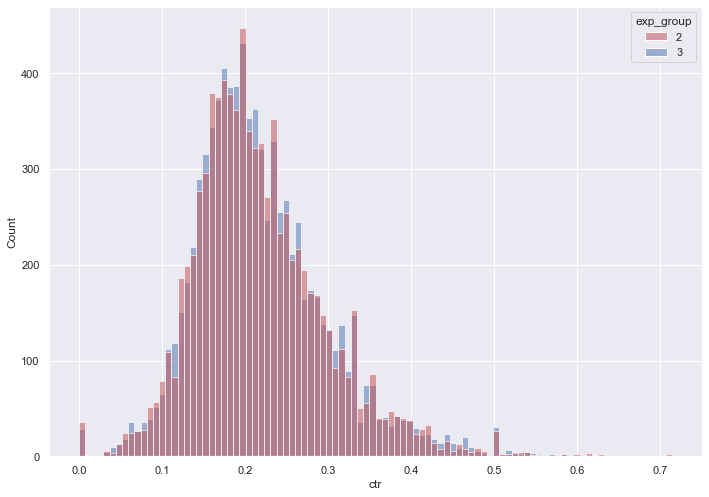

In [10]:
# Строим гистограммы распределения групп

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = data, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [8]:
# Создаем функцию симуляции проведения A/A-тестов, которая возвращает Series из p-value "проведенных" тестов

def AA_test_simulation(ctr1, ctr2, n_simulation=10000):
    p_values = []

    for _ in range(n_simulation):
        p_values.append(stats.ttest_ind(ctr1.sample(500),
                    ctr2.sample(500),
                    equal_var=False)[1])
        
    return pd.Series(p_values)

In [11]:
# Получаем p-values

p_values = AA_test_simulation(data[data.exp_group == 2].ctr, data[data.exp_group == 3].ctr)
p_values[:10]

0    0.903963
1    0.522579
2    0.804103
3    0.771668
4    0.307485
5    0.161044
6    0.558644
7    0.377470
8    0.564589
9    0.267138
dtype: float64

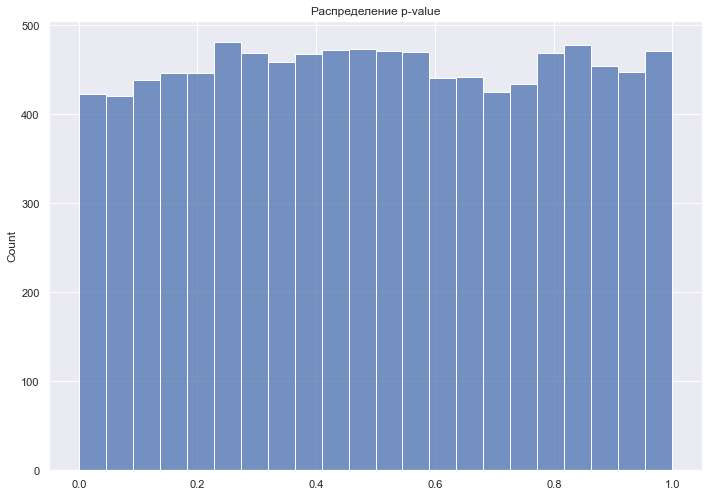

In [16]:
# Строим гистограмму распределения получившихся p-values

sns.histplot(p_values)
plt.title('Распределение p-value')
plt.show()

In [17]:
# Считаем какой процент p-values оказался меньше либо равен 0.05

len(p_values.where(p_values <= 0.05).dropna()) / len(p_values) * 100

4.68

Проведенный анализ показал, что система сплитования работает корректно, так как на симуляции 10000 A/A-тестов, p-value меньше 0.05 встречается в чуть меньше чем 5% случаев. Это означает, что с вероятностью примерно 95% наша система сплитования работает корректно.

# Анализ данных А/В-теста <a id='test'></a>

In [18]:
# Выгружаем данные

q = '''
        SELECT exp_group, 
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2022-07-13' and '2022-07-19'
              and exp_group in (1, 2)
        GROUP BY exp_group, user_id
    '''

data2 = ph.read_clickhouse(q, connection=connection)

In [19]:
# Смотрим на количество пользователей в группах

data2.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Количество пользователей в группах распределено примерно одинаково. Перейдем к проверке гипотез.

Мы проверяем результаты эксперимента по введению нового алгоритма рекомендаций - пользователю показываются посты, наиболее похожие на те, что он лайкал. Согласно гипотезе, нововведение должно увеличить CTR пользователя.  

Нулевая гипотеза - CTR в группах не отличается, алгоритм не работает.  
Альтернативная гипотеза - CTR в группах разный.

In [22]:
# T-test

stats.ttest_ind(data2[data2.exp_group == 1].ctr, data2[data2.exp_group == 2].ctr, equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Т-test показал, что различий в группах нет. Посмотрим на тест Манна-Уитни:

In [24]:
stats.mannwhitneyu(data2[data2.exp_group == 1].ctr, data2[data2.exp_group == 2].ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест же Манна-Уитни показал, что в группах есть значительные отличия. Посмотрим на средние и медианные CTR в каждой группе, а так построим распределение CTR на графике. 

In [25]:
print('Средние значения CTR:', round((data2[data2['exp_group'] == 1].ctr.mean()), 2), '/',
      round((data2[data2['exp_group'] == 2].ctr.mean()), 2))

print('Медианные значения CTR:', round((data2[data2['exp_group'] == 1].ctr.median()), 2), '/',
      round((data2[data2['exp_group'] == 2].ctr.median()), 2))

Средние значения CTR: 0.22 / 0.21
Медианные значения CTR: 0.2 / 0.14


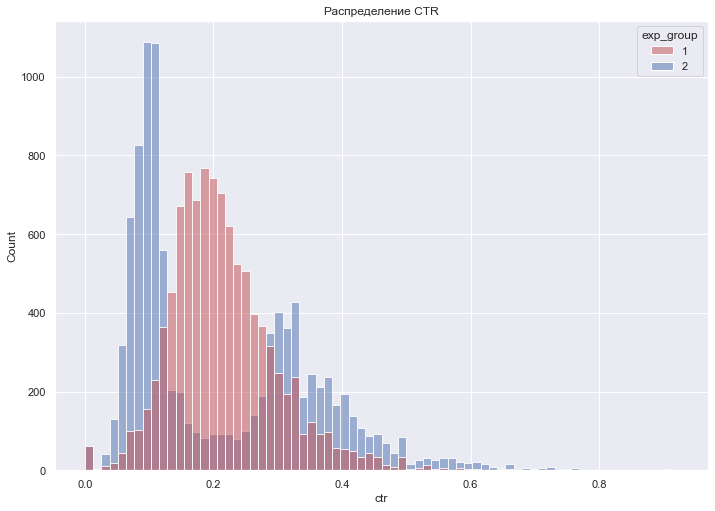

In [27]:
# Смотрим на распределение CTR

sns.set(rc={'figure.figsize':(11.7, 8.27)})
plt.title('Распределение CTR')
p = sns.histplot(data = data2, x = 'ctr', hue = 'exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)

Как видно на графике, распределение CTR в экспериментальной группе значительно отличается от контрольной. В экспериментальной группе распределение CTR имеет бимодальный вид, распределение в контрольной группе близко к нормальному распределению, отсюда некорректная работа t-testa, он не видит различий в группах.
Средние в группах практически одинаковые, медианные значения имеют отличия.

## Сглаженный CTR

Проведем теперь t-test на сглаженном CTR.

In [28]:
# Создаем функцию для расчета сглаженного CTR

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [29]:
# Расчитываем глобальный CTR для каждой группы

global_ctr_1 = data2[data2['exp_group'] == 1].likes.sum()/data2[data2['exp_group'] == 1].views.sum()
global_ctr_2 = data2[data2['exp_group'] == 2].likes.sum()/data2[data2['exp_group']==2].views.sum()

Расчитаем сглаженный CTR для первой группы и посмотрим на распределение до сглаживания и после.

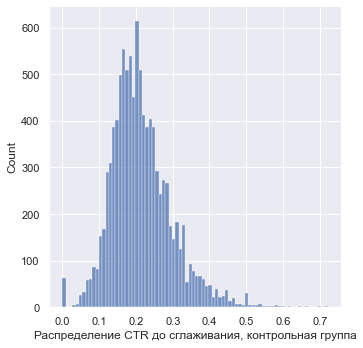

In [30]:
group_1 = data2[data2['exp_group'] == 1].copy()

sns.displot(group_1.ctr, kde=False)
plt.xlabel('Распределение CTR до сглаживания, контрольная группа')
plt.show()

In [31]:
# Расчитываем сглаженный CTR
group_1['smothed_ctr'] = group_1.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

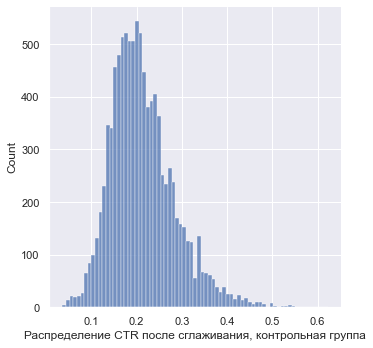

In [32]:
# Смотри на распределение сглаженного CTR

sns.displot(group_1.smothed_ctr, kde=False)
plt.xlabel('Распределение CTR после сглаживания, контрольная группа')
plt.show()

Сделаем то же самое для второй группы.

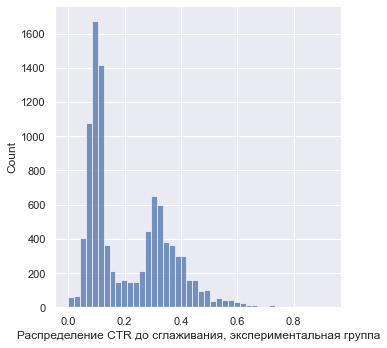

In [33]:
group_2 = data2[data2['exp_group'] == 2].copy()

sns.displot(group_2.ctr, kde=False)
plt.xlabel('Распределение CTR до сглаживания, экспериментальная группа')
plt.show()

In [34]:
group_2['smothed_ctr'] = group_2.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

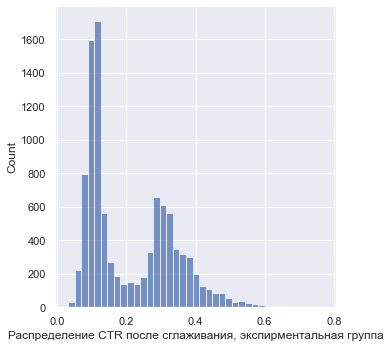

In [35]:
# Смотрим на распределение CTR

sns.displot(group_2.smothed_ctr, kde=False)
plt.xlabel('Распределение CTR после сглаживания, экспирментальная группа')
plt.show()

In [36]:
# T-test на сглаженном CTR

stats.ttest_ind(group_1.smothed_ctr, group_2.smothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

На сглаженном CTR t-test увидел отличия в группах.

## Пуассоновский бутстреп

In [38]:
# Функция для расчета глобального CTR c помощью бутстрепа

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    global_ctr1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    global_ctr2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    return global_ctr1, global_ctr2

In [39]:
# Собираем лайки и просмотры для расчета глобального CTR

likes1 = group_1.likes.to_numpy()
views1 = group_1.views.to_numpy()
likes2 = group_2.likes.to_numpy()
views2 = group_2.views.to_numpy()

In [40]:
# Считаем CTR

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

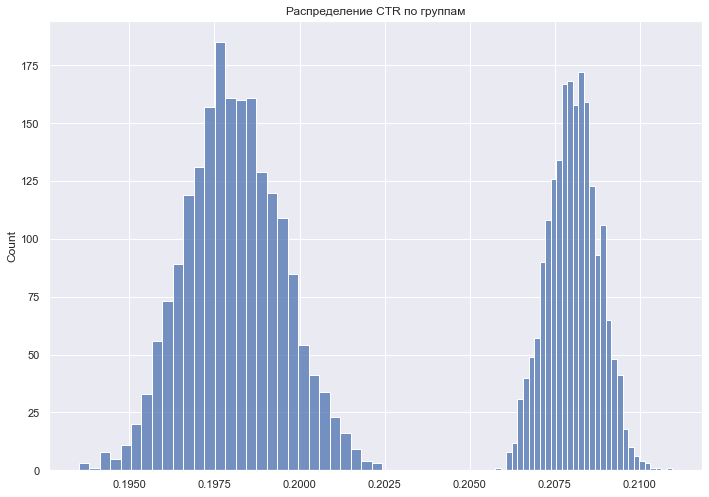

In [41]:
# Смотрим на распределение CTR по группам

sns.histplot(ctr1)
sns.histplot(ctr2)
plt.title('Распределение CTR по группам')
plt.show()

На графике видно, что CTR по группам значительно отличаются. Построим график распределения разницы CTR.

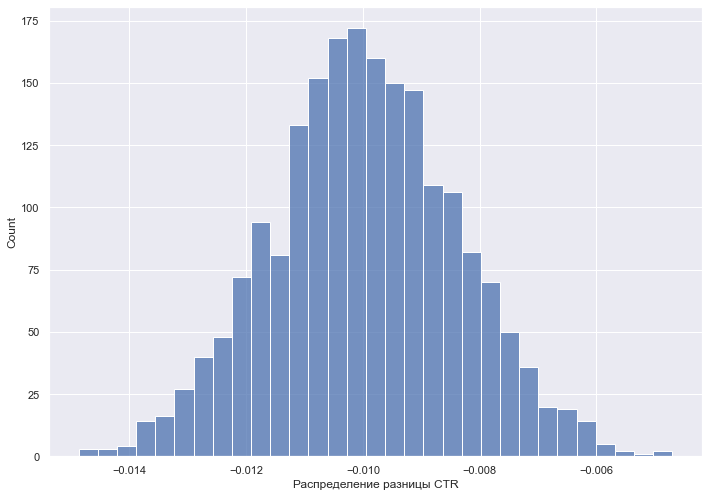

In [42]:
sns.histplot(ctr2 - ctr1)
plt.xlabel('Распределение разницы CTR')
plt.show()

На графике распределение с отрицательным значением, CTR экспериментальной группы меньше CTR контрольной группы.

# Вывод <a id='res'></a>

Мы провели анализ результатов AB-теста, который должен был показать увеличение CTR после внедрения нового алгоритма рекомендаций.  
Тест Манна-Уитни и t-test на сглаженном CTR выявили значимые отличия в контрольной и экспериментальной группах. Пуассоновский бутстреп для расчета разницы в CTR показал, что CTR экспериментальной группы меньше, чем в контрольной.  
Распределение CTR в экспериментальной группе имеет бимодальный вид, что может свидетельствовать о некорректной работе введенного алгоритма, возможно алгоритм еще недоработан, либо требуется большее время проведения эксперимента, чтобы увидеть результаты.  
На данный момент новый алгоритм не стоит внедрять на всех пользователей.

# Дополнительно: Linearization <a id='extra'></a>

## Анализ групп 0 и 3

In [44]:
# Выгружаем данные

q = '''
        SELECT exp_group, 
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (0, 3)
        GROUP BY exp_group, user_id
    '''

df1 = ph.read_clickhouse(q, connection=connection)

In [45]:
# Расчитываем общий CTR контрольной группы

ctr_control_1 = df1[df1['exp_group'] == 0].likes.sum()/df1[df1['exp_group'] == 0].views.sum()

In [46]:
# Расчитываем метрику для всех пользователей

df1['linearized_likes'] = df1['likes'] - df1['views'] * ctr_control_1

In [47]:
# Расчитаем p-value по CTR

stats.ttest_ind(df1[df1.exp_group == 0].ctr, df1[df1.exp_group == 3].ctr, equal_var = False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

In [48]:
# Расчитаем p-value по linearized likes

stats.ttest_ind(df1[df1.exp_group == 0].linearized_likes, df1[df1.exp_group == 3].linearized_likes, equal_var = False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

На данных группах в обоих вариантах расчета p-value получается очень маленьким.

## Анализ групп 1 и 2

In [49]:
# Выгружаем данные

q = '''
        SELECT exp_group, 
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
        FROM {db}.feed_actions 
        WHERE toDate(time) between '2022-07-13' and '2022-07-19'
        and exp_group in (1, 2)
        GROUP BY exp_group, user_id
    '''

df2 = ph.read_clickhouse(q, connection=connection)

In [50]:
# Расчитываем общий CTR контрольной группы

ctr_control_2 = df2[df2['exp_group'] == 1].likes.sum()/df2[df2['exp_group'] == 1].views.sum()

In [51]:
# Расчитываем метрику для всех пользователей

df2['linearized_likes'] = df2['likes'] - df2['views'] * ctr_control_2

In [52]:
# Расчитываем p-value по CTR

stats.ttest_ind(df2[df2.exp_group == 1].ctr, df2[df2.exp_group == 2].ctr, equal_var = False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

In [53]:
# Расчитаем p-value по linearized likes

stats.ttest_ind(df2[df2.exp_group == 1].linearized_likes, df2[df2.exp_group == 2].linearized_likes, equal_var = False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

## Вывод

Т-тест по CTR в данных группах не увидел отличий, а вот при проведении теста на расчитанной метрике linearized likes p-value получился гораздо меньше и показал значимые отличия в группах. 